# Import libraries

In [1]:
from datetime import timedelta
from functools import partial, reduce
from itertools import combinations, count, chain
from math import ceil
from multiprocessing import cpu_count

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
from scipy.stats import ks_2samp

from libs.web_tracking.facades.analysis import Analysis
from libs.web_tracking.measures.entropy import Entropy
from libs.web_tracking.measures.entropy_rate import EntropyRate
from libs.web_tracking.measures.predictability import Predictability
from libs.web_tracking.pre_processing.raw_data_processor import \
    RawDataProcessor
from libs.web_tracking.pre_processing.trajectories.binned_non_stationary_trajectory import \
    BinnedNonStationaryTrajectory
from libs.web_tracking.pre_processing.trajectories.binned_stationary_trajectory import \
    BinnedStationaryTrajectory
from libs.web_tracking.pre_processing.trajectories.sequential_non_stationary_trajectory import \
    SequentialNonStationaryTrajectory
from scripts.helpers import construct_subplot_axes

# Constants

In [2]:
# mpl.style.use('v2.0')
## line width frame
mpl.rcParams['figure.figsize']=(3.3, 2)
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.color'] = 'black'
# mpl.rcParams['text.fontsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
# xticks
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.labelpad'] = 4
mpl.rcParams['backend'] = 'ps'
mpl.rcParams['xtick.major.pad'] = 4
mpl.rcParams['ytick.major.pad'] = 4
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
params = {'mathtext.default': 'sf'}
plt.rc('figure', facecolor='w')
plt.rcParams.update(params)

In [3]:
LINE_STYLES =['-',  ':', '-.', (0, (3, 1, 1, 1, 1, 1)), '--']

# Variables

In [4]:
analysis = Analysis()

In [5]:
# processed data
processed = pd \
        .read_csv(
            '/bigdata/web_tracking/data/pre-processed/urls-v5.csv', 
            dtype={'id': int, 'panelist_id': int, 'prev_id': int}, 
            parse_dates=['used_at', 'left_at'],
            converters={
                'category_names'    : lambda text: None if pd.isnull(text) else tuple(text.split(',')),
                'category_names_top': lambda text: None if pd.isnull(text) or text == '' else tuple(text.split(',')),
                'category_names_sub': lambda text: None if pd.isnull(text) or text == '' else tuple(text.split(',')),
            }
        )


RDP  = RawDataProcessor(processed)
RDP.create_time_series(uid='id', 
                       user='panelist_id', 
                       url='url', 
                       domain='domain', 
                       category='category', 
                       starts='used_at', 
                       active_seconds='active_seconds')

TRAJECTORY_PROCESSED = RDP.df.copy()

USERS = pd.read_csv('/bigdata/web_tracking/data/original/users.csv').rename(columns={'panelist_id': 'user'})

## The steps of getting the following data is shown in Section "Entropy & Predictability Computation -> Binned-Non-Stationary"
SELECTED_USER_IDS = pd.read_csv('/bigdata/web_tracking/data/traj-non-stationary/selected_users.csv')

In [6]:
## -> The following datasets are imported simply, but the steps of creating those are displayed in "Entropy & Predictability Computation".
BIN_NON_STAT_RES = SELECTED_USER_IDS.merge(pd.read_csv('/bigdata/web_tracking/data/traj-non-stationary/trajectory-non-stationery-predicatability.csv'), on='user')
SEQ_NON_STAT_RES = SELECTED_USER_IDS.merge(pd.read_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-domain-aggregated-predicatability.csv'), on='user')
STAT_RES         = SELECTED_USER_IDS.merge(pd.read_csv('/bigdata/web_tracking/data/traj-binned/trajectory-binned-1-predictability.csv'), on='user')

# Top Domains

- According to Alexa: "A website has a Reach score of 5,000, this means that 5,000 people out of a sample of 1 million"[¹](https://www.klipfolio.com/metrics/marketing/reach-per-million-users#:~:text=Reach%20is%20an%20Alexa%20Web,installed%2C%20saw%20your%20site%20yesterday.), and they calculate it by using `Count Unique(People who saw your content per Day per Million Users)`
- So, we computed number of unique visitors per domain to compare our dataset with Alexa.
- Section 4 in the article.

In [7]:
alexa_top_5K = pd.read_csv('./data/alexa_GER_top5000.csv').drop(columns=['X1.nrow.file.Results.Result.Alexa.TopSites.Country.Sites.Site.'])

In [8]:
top_domains = TRAJECTORY_PROCESSED.top_level_domain.value_counts(normalize=True).to_frame() \
                    .reset_index().rename(columns={'index': 'domain', 'top_level_domain': 'visits'}) \
                    .assign(rank = lambda df: range(1, len(df)+1))

In [9]:
top_domains_5K  = top_domains.merge(alexa_top_5K, left_on='domain', right_on='url')
top_domains_1K  = top_domains.merge(alexa_top_5K.query("country_rank < 1001"), left_on='domain', right_on='url')
top_domains_500 = top_domains.merge(alexa_top_5K.query("country_rank < 501"), left_on='domain', right_on='url')

## Matching Domains between Alexa and Our Dataset

In [10]:
f'{len(top_domains_5K)} / 5000', f'{len(top_domains_1K)} / 1000', f'{len(top_domains_500)} / 500'

('3484 / 5000', '847 / 1000', '444 / 500')

## 5,000 Domains Correlation

In [11]:
display('Pearson Correlation Coefficient')
top_domains_5K[['visits', 'PageViews.PerMillion']].corr(method='pearson')

'Pearson Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.780473
PageViews.PerMillion,0.780473,1.000000


In [12]:
display('Spearman Correlation Coefficient')
top_domains_5K[['visits', 'PageViews.PerMillion']].corr(method='spearman')

'Spearman Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.477326
PageViews.PerMillion,0.477326,1.000000


## 1,000 Domains Correlation

In [13]:
display('Pearson Correlation Coefficient')
top_domains_1K[['visits', 'PageViews.PerMillion']].corr(method='pearson')

'Pearson Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.777852
PageViews.PerMillion,0.777852,1.000000


In [14]:
display('Spearman Correlation Coefficient')
top_domains_1K[['visits', 'PageViews.PerMillion']].corr(method='spearman')

'Spearman Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.429352
PageViews.PerMillion,0.429352,1.000000


## 500 Domains Correlation

In [15]:
display('Pearson Correlation Coefficient')
top_domains_500[['visits', 'PageViews.PerMillion']].corr(method='pearson')

'Pearson Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.774992
PageViews.PerMillion,0.774992,1.000000


In [16]:
display('Spearman Correlation Coefficient')
top_domains_500[['visits', 'PageViews.PerMillion']].corr(method='spearman')

'Spearman Correlation Coefficient'

,visits,PageViews.PerMillion
visits,1.000000,0.523886
PageViews.PerMillion,0.523886,1.000000


# $\Pi^{max}$ Stats: Confidence Intervals

- Section 5 in the Article.

In [17]:
def get_conf_interval(arr, percentage=.9):
    return st.t.interval(percentage, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))


def get_mean_with_intervals(df, var, intervals):
    return (
        np.mean(df[var]),
        *[ get_conf_interval(df[var], i) for i in intervals ]
    )

In [18]:
data = [
    get_mean_with_intervals(STAT_RES, 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(BIN_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(SEQ_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("gender == 'female'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("gender == 'male'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '[18,24]'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '(24,34]'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '(34,44]'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '(44,54]'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '(54,64]'"), 'domain_pi_max', [.90, .95]),
    get_mean_with_intervals(STAT_RES.merge(USERS, on='user').query("age_recode == '(64,80]'"), 'domain_pi_max', [.90, .95]),
]

indices = [
    'stationary', 'non_stationary', 'seq_non_stationary',
    'stationary_female', 'stationary_male',
    'stationary_18_24', 'stationary_24_34', 'stationary_34_44', 'stationary_44_54', 'stationary_54_64', 'stationary_64_80',
]

CONF_INTERVALS = pd.DataFrame(index=indices[:len(data)], columns=['mean', '.90_conf', '.95_conf'], data=data)

In [19]:
CONF_INTERVALS.style \
    .background_gradient('Greens', subset=['mean']) \
    .format({
        'mean': '{0:.6f}',
        '.90_conf': lambda t: f'[{t[0]:.6f}, {t[1]:.6f}]',
        '.95_conf': lambda t: f'[{t[0]:.6f}, {t[1]:.6f}]',
    })

,mean,.90_conf,.95_conf
stationary,0.851068,"[0.848492, 0.853644]","[0.847997, 0.854138]"
non_stationary,0.587956,"[0.584519, 0.591393]","[0.583860, 0.592052]"
seq_non_stationary,0.687751,"[0.684635, 0.690868]","[0.684037, 0.691466]"
stationary_female,0.857304,"[0.853684, 0.860924]","[0.852989, 0.861620]"
stationary_male,0.845189,"[0.841557, 0.848822]","[0.840860, 0.849519]"
stationary_18_24,0.867007,"[0.859924, 0.874090]","[0.858552, 0.875462]"
stationary_24_34,0.842590,"[0.836917, 0.848264]","[0.835823, 0.849358]"
stationary_34_44,0.830752,"[0.824022, 0.837483]","[0.822723, 0.838782]"
stationary_44_54,0.853048,"[0.847638, 0.858458]","[0.846597, 0.859500]"
stationary_54_64,0.859433,"[0.854254, 0.864612]","[0.853257, 0.865609]"


In [62]:
display(
pd.DataFrame(
    data = [
        get_mean_with_intervals(STAT_RES, 'domain_pi_rand', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'domain_pi_unc', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'domain_pi_max', [.90, .95]),
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{rand}$", "$\Pi^{unc}$", "$\Pi^{max}$", ]
    
) \
.style \
    .background_gradient('Oranges', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })
)

display(
pd.DataFrame(
    data = [
        get_mean_with_intervals(BIN_NON_STAT_RES, 'domain_pi_rand', [.90, .95]),
        get_mean_with_intervals(BIN_NON_STAT_RES, 'domain_pi_unc', [.90, .95]),
        get_mean_with_intervals(BIN_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{rand}$", "$\Pi^{unc}$", "$\Pi^{max}$", ]
    
) \
.style \
    .background_gradient('Blues', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })
)

pd.DataFrame(
    data = [
        get_mean_with_intervals(SEQ_NON_STAT_RES, 'domain_pi_rand', [.90, .95]),
        get_mean_with_intervals(SEQ_NON_STAT_RES, 'domain_pi_unc', [.90, .95]),
        get_mean_with_intervals(SEQ_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{rand}$", "$\Pi^{unc}$", "$\Pi^{max}$", ]
    
) \
.style \
    .background_gradient('Greens', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })

,Mean,.90 CI,.95 CI
$\Pi^{rand}$,0.0140,"[0.0135, 0.0144]","[0.0135, 0.0145]"
$\Pi^{unc}$,0.5432,"[0.5373, 0.5491]","[0.5361, 0.5503]"
$\Pi^{max}$,0.8511,"[0.8485, 0.8536]","[0.8480, 0.8541]"


,Mean,.90 CI,.95 CI
$\Pi^{rand}$,0.0140,"[0.0135, 0.0144]","[0.0135, 0.0145]"
$\Pi^{unc}$,0.4123,"[0.4080, 0.4166]","[0.4072, 0.4174]"
$\Pi^{max}$,0.5880,"[0.5845, 0.5914]","[0.5839, 0.5921]"


,Mean,.90 CI,.95 CI
$\Pi^{rand}$,0.0108,"[0.0104, 0.0111]","[0.0103, 0.0112]"
$\Pi^{unc}$,0.4760,"[0.4718, 0.4801]","[0.4710, 0.4809]"
$\Pi^{max}$,0.6878,"[0.6846, 0.6909]","[0.6840, 0.6915]"


In [60]:
display(
pd.DataFrame(
    data = [
        get_mean_with_intervals(STAT_RES, 'domain_pi_rand', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'domain_pi_unc', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'domain_pi_max', [.90, .95]),
    ],
    columns=['mean', '.90_conf', '.95_conf'],
    index = ["$\Pi^{rand}_{domain}$", "$\Pi^{unc}_{domain}$", "$\Pi^{max}_{domain}$", ]
    
) \
.style \
    .background_gradient('YlOrBr', subset=['mean']) \
    .format({
        'mean': '{0:.4f}',
        '.90_conf': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95_conf': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })
)

pd.DataFrame(
    data = [
        get_mean_with_intervals(STAT_RES, 'category_pi_rand', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'category_pi_unc', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'category_pi_max', [.90, .95])
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{rand}_{category}$", "$\Pi^{unc}_{category}$", "$\Pi^{max}_{category}$", ]
    
) \
.style \
    .background_gradient('PuBu', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })

,mean,.90_conf,.95_conf
$\Pi^{rand}_{domain}$,0.0140,"[0.0135, 0.0144]","[0.0135, 0.0145]"
$\Pi^{unc}_{domain}$,0.5432,"[0.5373, 0.5491]","[0.5361, 0.5503]"
$\Pi^{max}_{domain}$,0.8511,"[0.8485, 0.8536]","[0.8480, 0.8541]"


,Mean,.90 CI,.95 CI
$\Pi^{rand}_{category}$,0.0378,"[0.0371, 0.0385]","[0.0369, 0.0386]"
$\Pi^{unc}_{category}$,0.5811,"[0.5759, 0.5862]","[0.5749, 0.5872]"
$\Pi^{max}_{category}$,0.8612,"[0.8588, 0.8636]","[0.8583, 0.8640]"


# Browsing Behavior Stats: Confidence Intervals

- Section 5.2 Impact of temporal resolution in the Article.

In [19]:
stats_per_ind_raw = TRAJECTORY_PROCESSED \
                    .groupby('user', as_index=False) \
                    .agg({'domain': 'nunique', 'active_seconds': 'mean'})

In [20]:
stats_per_ind_raw_selected = SELECTED_USER_IDS \
    .merge(TRAJECTORY_PROCESSED
           .groupby('user', as_index=False)
           .agg({'domain': 'nunique', 'active_seconds': 'mean'}), on='user')

## Comparison between Raw and Filtered Trajectory

In [21]:
data = [
    (*get_mean_with_intervals(stats_per_ind_raw, 'domain', [.90, .95]), *get_mean_with_intervals(stats_per_ind_raw, 'active_seconds', [.90, .95])),
    (*get_mean_with_intervals(stats_per_ind_raw_selected, 'domain', [.90, .95]), *get_mean_with_intervals(stats_per_ind_raw_selected, 'active_seconds', [.90, .95])),
]

indices = ['raw', 'filtered',]


pd.DataFrame(index=indices[:len(data)], columns=['domain', 'domain_conf_90', 'domain_conf_95', 'active_seconds', 'active_seconds_conf_90', 'active_seconds_conf_95'], data=data) \
    .style \
            .format({
                'domain'                : '{0:.2f}',
                'active_seconds'        : '{0:.2f}',
                'domain_conf_90'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
                'active_seconds_conf_90': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
                'domain_conf_95'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
                'active_seconds_conf_95': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            })

,domain,domain_conf_90,domain_conf_95,active_seconds,active_seconds_conf_90,active_seconds_conf_95
raw,108.33,"[104.10, 112.56]","[103.28, 113.38]",36.91,"[35.75, 38.07]","[35.53, 38.29]"
filtered,151.16,"[145.84, 156.48]","[144.81, 157.50]",35.18,"[34.15, 36.21]","[33.95, 36.41]"


## Raw Trajectory

### per Gender

In [22]:
USERS.merge(stats_per_ind_raw, on='user') \
    .groupby('gender') \
    .agg({'domain': 'mean', 'active_seconds': 'mean'}) \
    .merge(
        USERS \
            .merge(stats_per_ind_raw, on='user') \
            .groupby('gender') \
            .agg({'domain': list, 'active_seconds': list}) \
            .rename(columns={'domain': 'un_domain_list', 'active_seconds': 'mean_active_seconds_list'}),
        left_index=True, right_index=True,
    ) \
    .assign(
        domain_conf_90         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.90)),
        domain_conf_95         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.95)),
        active_seconds_conf_90 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.90)),
        active_seconds_conf_95 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.95)),
    ) \
    .drop(columns=['un_domain_list', 'mean_active_seconds_list']) \
    .style \
        .format({
            'domain'                : '{0:.2f}',
            'active_seconds'        : '{0:.2f}',
            'domain_conf_90'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_90': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'domain_conf_95'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_95': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
        })

,domain,active_seconds,domain_conf_90,domain_conf_95,active_seconds_conf_90,active_seconds_conf_95
gender,,,,,,
female,96.53,40.25,"[91.28, 101.79]","[90.27, 102.80]","[38.32, 42.18]","[37.95, 42.55]"
male,120.85,33.44,"[114.19, 127.50]","[112.92, 128.78]","[32.22, 34.67]","[31.98, 34.91]"


### per Age

In [23]:
USERS.merge(stats_per_ind_raw, on='user') \
    .groupby('age_recode') \
    .agg({'domain': 'mean', 'active_seconds': 'mean'}) \
    .merge(
        USERS \
            .merge(stats_per_ind_raw, on='user') \
            .groupby('age_recode') \
            .agg({'domain': list, 'active_seconds': list}) \
            .rename(columns={'domain': 'un_domain_list', 'active_seconds': 'mean_active_seconds_list'}),
        left_index=True, right_index=True,
    ) \
    .assign(
        domain_conf_90         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.90)),
        domain_conf_95         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.95)),
        active_seconds_conf_90 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.90)),
        active_seconds_conf_95 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.95)),
    ) \
    .drop(columns=['un_domain_list', 'mean_active_seconds_list']) \
    .style \
        .format({
            'domain'                : '{0:.2f}',
            'active_seconds'        : '{0:.2f}',
            'domain_conf_90'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_90': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'domain_conf_95'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_95': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
        })

,domain,active_seconds,domain_conf_90,domain_conf_95,active_seconds_conf_90,active_seconds_conf_95
age_recode,,,,,,
"(24,34]",96.67,32.80,"[88.03, 105.30]","[86.37, 106.97]","[30.27, 35.32]","[29.78, 35.81]"
"(34,44]",99.30,33.89,"[89.11, 109.50]","[87.15, 111.46]","[31.47, 36.32]","[31.00, 36.79]"
"(44,54]",122.06,37.23,"[113.08, 131.05]","[111.35, 132.78]","[35.30, 39.15]","[34.93, 39.52]"
"(54,64]",130.03,40.65,"[119.35, 140.71]","[117.30, 142.76]","[38.19, 43.10]","[37.71, 43.58]"
"(64,80]",109.76,50.27,"[89.32, 130.19]","[85.33, 134.18]","[37.53, 63.02]","[35.04, 65.51]"
"[18,24]",81.11,36.85,"[72.40, 89.81]","[70.72, 91.49]","[34.07, 39.64]","[33.53, 40.17]"


## Filtered Trajectory

### per Gender

In [24]:
USERS.merge(stats_per_ind_raw_selected, on='user') \
    .groupby('gender') \
    .agg({'domain': 'mean', 'active_seconds': 'mean'}) \
    .merge(
        USERS \
            .merge(stats_per_ind_raw_selected, on='user') \
            .groupby('gender') \
            .agg({'domain': list, 'active_seconds': list}) \
            .rename(columns={'domain': 'un_domain_list', 'active_seconds': 'mean_active_seconds_list'}),
        left_index=True, right_index=True,
    ) \
    .assign(
        domain_conf_90         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.90)),
        domain_conf_95         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.95)),
        active_seconds_conf_90 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.90)),
        active_seconds_conf_95 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.95)),
    ) \
    .drop(columns=['un_domain_list', 'mean_active_seconds_list']) \
    .style \
        .format({
            'domain'                : '{0:.2f}',
            'active_seconds'        : '{0:.2f}',
            'domain_conf_90'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_90': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'domain_conf_95'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_95': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
        })

,domain,active_seconds,domain_conf_90,domain_conf_95,active_seconds_conf_90,active_seconds_conf_95
gender,,,,,,
female,140.22,37.34,"[133.46, 146.99]","[132.16, 148.29]","[35.83, 38.85]","[35.54, 39.14]"
male,161.47,33.15,"[153.36, 169.57]","[151.81, 171.13]","[31.74, 34.56]","[31.47, 34.83]"


### per Age

In [25]:
USERS.merge(stats_per_ind_raw_selected, on='user') \
    .groupby('age_recode') \
    .agg({'domain': 'mean', 'active_seconds': 'mean'}) \
    .merge(
        USERS \
            .merge(stats_per_ind_raw_selected, on='user') \
            .groupby('age_recode') \
            .agg({'domain': list, 'active_seconds': list}) \
            .rename(columns={'domain': 'un_domain_list', 'active_seconds': 'mean_active_seconds_list'}),
        left_index=True, right_index=True,
    ) \
    .assign(
        domain_conf_90         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.90)),
        domain_conf_95         = lambda df: df['un_domain_list'].apply(partial(get_conf_interval, percentage=.95)),
        active_seconds_conf_90 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.90)),
        active_seconds_conf_95 = lambda df: df['mean_active_seconds_list'].apply(partial(get_conf_interval, percentage=.95)),
    ) \
    .drop(columns=['un_domain_list', 'mean_active_seconds_list']) \
    .style \
        .format({
            'domain'                : '{0:.2f}',
            'active_seconds'        : '{0:.2f}',
            'domain_conf_90'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_90': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'domain_conf_95'        : lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
            'active_seconds_conf_95': lambda t: f'[{t[0]:.2f}, {t[1]:.2f}]',
        })

,domain,active_seconds,domain_conf_90,domain_conf_95,active_seconds_conf_90,active_seconds_conf_95
age_recode,,,,,,
"(24,34]",143.15,29.36,"[131.75, 154.56]","[129.55, 156.75]","[28.00, 30.71]","[27.74, 30.97]"
"(34,44]",155.58,29.32,"[141.43, 169.73]","[138.69, 172.47]","[27.55, 31.08]","[27.21, 31.42]"
"(44,54]",157.41,36.59,"[146.96, 167.86]","[144.95, 169.88]","[34.52, 38.66]","[34.13, 39.06]"
"(54,64]",164.48,41.61,"[151.92, 177.04]","[149.50, 179.46]","[38.66, 44.56]","[38.09, 45.13]"
"(64,80]",142.94,40.17,"[118.74, 167.14]","[113.99, 171.90]","[35.89, 44.44]","[35.05, 45.29]"
"[18,24]",123.77,34.44,"[112.21, 135.33]","[109.97, 137.58]","[31.70, 37.18]","[31.17, 37.72]"


# Distribution of Number of Visited Domains by Users (Fig.3)

In [26]:
d1 = SELECTED_USER_IDS.merge(TRAJECTORY_PROCESSED[TRAJECTORY_PROCESSED['starts'] < TRAJECTORY_PROCESSED['starts'].min() + timedelta(days=1)], on='user') \
        .groupby('user') \
        .agg({'top_level_domain': 'count'}).top_level_domain \
        .value_counts(normalize=True).to_frame() \
        .rename(columns={'top_level_domain': '$P(N)_{1D}$'}).sort_index()

w1 = SELECTED_USER_IDS.merge(TRAJECTORY_PROCESSED[TRAJECTORY_PROCESSED['starts'] < TRAJECTORY_PROCESSED['starts'].min() + timedelta(weeks=1)], on='user') \
        .groupby('user') \
        .agg({'top_level_domain': 'count'}).top_level_domain \
        .value_counts(normalize=True).to_frame() \
        .rename(columns={'top_level_domain': '$P(N)_{1W}$'}).sort_index()

w2 = SELECTED_USER_IDS.merge(TRAJECTORY_PROCESSED[TRAJECTORY_PROCESSED['starts'] < TRAJECTORY_PROCESSED['starts'].min() + timedelta(weeks=2)], on='user') \
        .groupby('user') \
        .agg({'top_level_domain': 'count'}).top_level_domain \
        .value_counts(normalize=True).to_frame() \
        .rename(columns={'top_level_domain': '$P(N)_{2W}$'}).sort_index()

w3 = SELECTED_USER_IDS.merge(TRAJECTORY_PROCESSED[TRAJECTORY_PROCESSED['starts'] < TRAJECTORY_PROCESSED['starts'].min() + timedelta(weeks=3)], on='user') \
        .groupby('user') \
        .agg({'top_level_domain': 'count'}).top_level_domain \
        .value_counts(normalize=True).to_frame() \
        .rename(columns={'top_level_domain': '$P(N)_{3W}$'}).sort_index()

w4 = SELECTED_USER_IDS.merge(TRAJECTORY_PROCESSED[TRAJECTORY_PROCESSED['starts'] < TRAJECTORY_PROCESSED['starts'].min() + timedelta(weeks=4)], on='user') \
        .groupby('user') \
        .agg({'top_level_domain': 'count'}).top_level_domain \
        .value_counts(normalize=True).to_frame() \
        .rename(columns={'top_level_domain': '$P(N)_{4W}$'}).sort_index()

df_cdf = d1 \
            .merge(w1, left_index=True, right_index=True, how='outer') \
            .merge(w2, left_index=True, right_index=True, how='outer') \
            .merge(w3, left_index=True, right_index=True, how='outer') \
            .merge(w4, left_index=True, right_index=True, how='outer') \
            .fillna(0).cumsum()

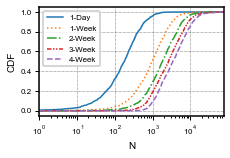

In [27]:
TITLE = 'The Distribution of Number of Locations $N$ for Various Time Periods'
ARGS  = dict(grid=True, logx=True)

ax = df_cdf.plot(**ARGS)

ax.set_xlabel('N')
ax.set_ylabel('CDF')

styles = LINE_STYLES[:len(ax.get_lines())]

for line, style in zip(ax.get_lines(), styles):
    line.set_linestyle(style)

ax.legend(ax.get_lines(), ['1-Day', '1-Week', '2-Week', '3-Week', '4-Week'], loc='best')

# Absolute Change in $\Pi^{max}$ with Increasing Trajectory Length for 100 Users 

- Section 5.2 Impact of stationarity in trajectories in the article.
- Figure 3 in the article.

In [258]:
def quantile(n):
    def quantile_(x):
        return np.quantile(x, n)
    quantile_.__name__ = 'quantile_%s' % n
    return quantile_


def execute_incremental_predictability(df, min_len, max_len, points):
    
    increment = (max_len-min_len)//points

    for s in range(min_len, max_len+increment, increment):
        df[f'domain_{s}'] = df['domain'].apply(lambda l: l[:s])
        df[f'domain_{s}_unique'] = df[f'domain_{s}'].apply(set).apply(len)
        df[f'domain_{s}_entropy_lz'] = df[f'domain_{s}'].apply(EntropyRate.__lempel_ziv_estimate__)
        df[f'domain_{s}_predictability'] = df.apply(lambda r: Predictability.__pi__(r[f'domain_{s}_unique'], r[f'domain_{s}_entropy_lz']),axis=1)

    return df


MIN = 10
MAX = 1855
POINTS = 1000
INC = (MAX-MIN)//POINTS

In [119]:
BNST = BinnedNonStationaryTrajectory(TRAJECTORY_PROCESSED)
BNST_domain, = BNST.create(features=['domain'], bin_size=60).values()
BNST_domain.to_csv('/bigdata/web_tracking/data/traj-non-stationary/trajectory-non-stationery.csv', index=False)

BNST_domain = pd.read_csv('/bigdata/web_tracking/data/traj-non-stationary/trajectory-non-stationery.csv')
BNST_domain_sample = BNST_domain \
                        .groupby('user', as_index=False) \
                        .agg({
                            'non_stationary_group': 'count',
                            'domain': list
                        }) \
                        .nlargest(100, 'non_stationary_group') \
                        .tail(100)
   
BNST_domain_sample_split = np.array_split(BNST_domain_sample.copy(), cpu_count())
with mp.Pool(cpu_count()) as pool:
    DF_INC_PREDICTABILITY = pd.concat(pool.map(partial(execute_incremental_predictability, min_len=MIN, max_len=MAX, points=POINTS), BNST_domain_sample_split))
DF_INC_PREDICTABILITY.to_csv('/bigdata/web_tracking/data/traj-non-stationary/trajectory-non-stationary-100-nlargest-100-tail.csv', index=False)

In [120]:
DF_INC_PREDICTABILITY = pd.read_csv('/bigdata/web_tracking/data/traj-non-stationary/trajectory-non-stationary-100-nlargest-100-tail.csv')

COLS_PRED = [f'domain_{s}_predictability'for s in range(MIN, MAX+INC, INC)]

DF_INC_PREDICTABILITY_view = DF_INC_PREDICTABILITY[['user', *COLS_PRED]].set_index('user').stack().to_frame() \
                                .reset_index() \
                                .assign(level_1 = lambda df: df['level_1'].apply(lambda text: int(text.split('_')[1]))) \
                                .rename(columns={'level_1': 'length', 0: 'pi_max'}) \
                                .assign(
                                    is_user_same = lambda df: (df['user'] == df['user'].shift()),
                                    pi_max_diff = lambda df: df['is_user_same'] * (df['pi_max'] - df['pi_max'].shift())
                                )

DF_INC_PREDICTABILITY_view_absolute = DF_INC_PREDICTABILITY[['user', *COLS_PRED]].set_index('user').stack().to_frame() \
                                        .reset_index() \
                                        .assign(level_1 = lambda df: df['level_1'].apply(lambda text: int(text.split('_')[1]))) \
                                        .rename(columns={'level_1': 'length', 0: 'pi_max'}) \
                                        .assign(
                                            is_user_same = lambda df: (df['user'] == df['user'].shift()),
                                            pi_max_diff = lambda df: (df['is_user_same'] * (df['pi_max'] - df['pi_max'].shift())).apply(abs)
                                        ).drop(columns=['is_user_same'])

DF_INC_PREDICTABILITY_view_absolute_mean = DF_INC_PREDICTABILITY_view_abs \
                                                .groupby('length', as_index=False) \
                                                .agg({'pi_max': 'mean', 'pi_max_diff': 'mean'})

In [300]:
DF_INC_PREDICTABILITY_view_absolute_lines = DF_INC_PREDICTABILITY_view_absolute \
                                                .groupby('length') \
                                                .agg({
                                                    'pi_max_diff': ['min', 'max', quantile(.05), quantile(.95)]
                                                })

DF_INC_PREDICTABILITY_view_absolute_lines.columns = ['min', 'max', 'quantile_.05', 'quantile_.95']

DF_INC_PREDICTABILITY_view_absolute_lines = DF_INC_PREDICTABILITY_view_absolute_lines \
                                                .reset_index() \
                                                .rename(columns={'index': 'length'}) \
                                                .query('length > 10')


/home/karacaliko/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [302]:
DF_INC_PREDICTABILITY_view_absolute_mean = DF_INC_PREDICTABILITY_view_absolute_mean.query('length > 10')

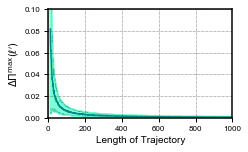

In [337]:
ARGS = dict(grid=True, xlim=(0, 1000), ylim=(0, .1), color='darkcyan', legend=None,)

ax = DF_INC_PREDICTABILITY_view_absolute_mean \
        .plot(x='length', y='pi_max_diff', **ARGS)

DF_INC_PREDICTABILITY_view_absolute_lines \
    .plot(x='length', y=['quantile_.05', 'quantile_.95'], ax=ax, linewidth=0.5, linestyle=':', **ARGS)

ax \
    .fill_between(DF_INC_PREDICTABILITY_view_absolute_lines['length'],
                  DF_INC_PREDICTABILITY_view_absolute_lines['quantile_.05'],
                  DF_INC_PREDICTABILITY_view_absolute_lines['quantile_.95'],
                  color='aquamarine')

# ax.legend(["Mean: $\Delta \Pi^{max}(\ell')$"])
ax.set_xlabel('Length of Trajectory')
ax.set_ylabel("$\Delta \Pi^{max}(\ell')$", )
# ax.get_figure().savefig(f'./figures/results/pi-max-diff-quantiles-over-length.pdf', bbox_inches='tight')

# Impact of Stationarity in the Trajectories

- Section 5.2 Impact of stationarity in trajectories in the article.
- Figure 4 in the article.

['0.5811', '0.6767', '0.8308']

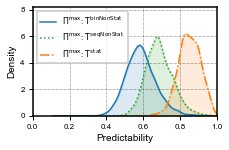

In [66]:
# AX_COLORS = ['deepskyblue', 'forestgreen', 'coral']
AX_COLORS = ['#1f77b4', '#2ca02c', '#ff7f0e']
ARGS = dict(xlim=(0, 1), ylim=(0, 8.2), grid=True)


ax = BIN_NON_STAT_RES['domain_pi_max'] \
        .plot.kde(**ARGS, color=AX_COLORS[0])

SEQ_NON_STAT_RES['domain_pi_max'] \
    .plot.kde(**ARGS, color=AX_COLORS[1], ax=ax)

STAT_RES['domain_pi_max'] \
    .plot.kde(**ARGS, color=AX_COLORS[2], ax=ax)

ax.set_xlabel('Predictability')

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    x = line.get_xydata()[:, 0]
    y = line.get_xydata()[:, 1]
    ax.fill_between(x, y, color=color, alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])
    line.set_linestyle(style)

ax.legend(ax.get_lines(), ['$\Pi^{max}$: $T^{binNonStat}$', '$\Pi^{max}$: $T^{seqNonStat}$', '$\Pi^{max}$: $T^{stat}$',], loc='best')
FILE_NAME = 'impact-of-stationarity-in-trajectories.pdf'
# ax.get_figure().savefig(f'./figures/results/{FILE_NAME}', bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

In [79]:
pd.DataFrame(
    data = [
        get_mean_with_intervals(BIN_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
        get_mean_with_intervals(SEQ_NON_STAT_RES, 'domain_pi_max', [.90, .95]),
        get_mean_with_intervals(STAT_RES, 'domain_pi_max', [.90, .95])
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{max}$: $T^{binNonStat}$", "$\Pi^{max}$: $T^{seqNonStat}$", "$\Pi^{max}$: $T^{stat}$", ]
    
) \
.style \
    .background_gradient('GnBu', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })

,Mean,.90 CI,.95 CI
$\Pi^{max}$: $T^{binNonStat}$,0.5880,"[0.5845, 0.5914]","[0.5839, 0.5921]"
$\Pi^{max}$: $T^{seqNonStat}$,0.6878,"[0.6846, 0.6909]","[0.6840, 0.6915]"
$\Pi^{max}$: $T^{stat}$,0.8511,"[0.8485, 0.8536]","[0.8480, 0.8541]"


# Impact of Temporal Resolution on the Predictability

- Section 5.2 Impact of temporal resolution in trajectories in the article.
- Figure 5 in the article.

In [97]:
def generate_binned_trajectory(df, bin_size):
    BST = BinnedStationaryTrajectory(df)
    return BST.create(bin_size=bin_size)

In [98]:
TRAJECTORY_PROCESSED_sample = TRAJECTORY_PROCESSED.query("user == 477537641")
TRAJECTORY_PROCESSED_temporal = pd.concat([
    generate_binned_trajectory(TRAJECTORY_PROCESSED_sample, i).groupby('user', as_index=False).agg({'domain': list}).assign(bin=i)
    for i in [15, 30, 45, *range(60, 16*60, 60)]
]).reset_index(drop=True)
df_impact_temporal = TRAJECTORY_PROCESSED_temporal \
                        .assign(
                            visits          = lambda df: df['domain'].apply(len),
                            unique          = lambda df: df['domain'].apply(lambda ds: len(set(ds))),
                            entropy_random  = lambda df: df['domain'].apply(Entropy.__random_entropy__),
                            entropy_shannon = lambda df: df['domain'].apply(Entropy.__shannon_entropy__),
                            entropy_lz      = lambda df: df['domain'].apply(EntropyRate.__lempel_ziv_estimate__),
                            pi_max          = lambda df: df.apply(lambda r: Predictability.__pi__(r['unique'], r['entropy_lz']), axis=1),
                            bin_size        = lambda df: [ f"{b/60:.2f}" if b < 60 else f"{b//60}" for b in df.bin ]
                        ) \
                        .drop(columns=['domain'])

/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


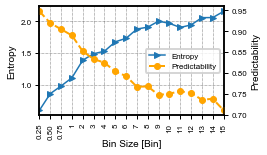

In [99]:
ax = df_impact_temporal \
        .plot(x='bin_size', 
              y='entropy_lz', 
              grid=True, 
              marker='>', label='Entropy')

ax.set_ylabel('Entropy',)
ax.set_xlabel('Bin Size [Bin]', labelpad=0)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))

ax_twinx = ax.twinx()
l = ax_twinx \
        .plot(df_impact_temporal.bin_size, df_impact_temporal.pi_max, linewidth=2.0, color='orange', marker='o', linestyle='--', label='$\Pi^{max}$')
ax_twinx.set_ylabel('Predictability')
ls = [*ax.get_lines(), *l]
ax.legend(ls, ['Entropy', 'Predictability'], loc=7)

FILE_NAME = 'impact-of-temporal-resolution-v2.pdf'
# ax.get_figure().savefig(f'./figures/results/{FILE_NAME}', bbox_inches='tight')

# Impact of Spatial Resolution on the Predictability

- Section 5.3 Impact of spatial resolution in trajectories in the article.
- Figure 7 in the article.

In [35]:
TRAJECTORY_RAW = pd \
                    .read_csv('/bigdata/web_tracking/data/original/urls.csv', usecols=['id', 'panelist_id', 'url'], dtype={'id': int}) \
                    .rename(columns={'panelist_id': 'user', 'id': 'uid'}) \
                    .merge(SELECTED_USER_IDS, on='user') \
                    .merge(TRAJECTORY_PROCESSED, on=['uid', 'user'])

In [40]:
RDP = RawDataProcessor(TRAJECTORY_RAW)
RDP.create_time_series(uid='uid', 
                       user='user', 
                       url='url', 
                       domain='domain', 
                       category='category_names', 
                       starts='starts', 
                       active_seconds='active_seconds')
TRAJECTORY_RAW = RDP.df.copy()

In [41]:
SEQ_NON_STAT = SequentialNonStationaryTrajectory(TRAJECTORY_RAW)
SEQ_NON_STAT_TRAJ = SEQ_NON_STAT.create(threshold=180, features=['url', 'domain', 'category'])

In [48]:
SEQ_NON_STAT_url_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['url'], features=['url'], workers=cpu_count())
SEQ_NON_STAT_url_predictability = analysis.compute_predictability(SEQ_NON_STAT_url_entropy, features=['url'])

/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/karacaliko/workspace/limits-of-predictability-in-web-mobility/libs/web_tracking/measures/predictability.py:78: RuntimeWarning: invalid value encountered in log2
  return -x*np.log2(x) - (1 - x)*(np.log2(1-x)) + (1 - x)*(np.log2(n-1)) - s


In [49]:
SEQ_NON_STAT_domain_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['domain'], features=['domain'], workers=cpu_count())
SEQ_NON_STAT_domain_predictability = analysis.compute_predictability(SEQ_NON_STAT_domain_entropy, features=['domain'])

In [52]:
SEQ_NON_STAT_category_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['category'], features=['category'], workers=cpu_count())
SEQ_NON_STAT_category_predictability = analysis.compute_predictability(SEQ_NON_STAT_category_entropy, features=['category'])

In [54]:
SEQ_NON_STAT_url_predictability \
    .to_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-url-predictability.csv', index=False)

SEQ_NON_STAT_domain_predictability \
    .to_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-domain-predictability.csv', index=False)

SEQ_NON_STAT_category_predictability \
    .to_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-category-predictability.csv', index=False)

In [67]:
SEQ_NON_STAT_url_predictability = pd.read_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-url-predictability.csv')
SEQ_NON_STAT_domain_predictability = pd.read_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-domain-predictability.csv')
SEQ_NON_STAT_category_predictability = pd.read_csv('/bigdata/web_tracking/data/traj-domain-aggregated/trajectory-aggregated-category-predictability.csv')

['0.4227', '0.6767', '0.6940']

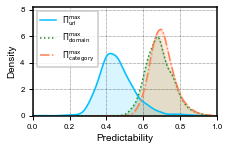

In [76]:
AX_COLORS = ['deepskyblue', 'forestgreen', 'coral']
# AX_COLORS = ['#1f77b4', '#2ca02c', '#ff7f0e']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8.2), color=AX_COLORS)

ax = SEQ_NON_STAT_url_predictability[['user', 'url_pi_max']] \
        .merge(SEQ_NON_STAT_domain_predictability[['user', 'domain_pi_max']], on='user') \
        .merge(SEQ_NON_STAT_category_predictability[['user', 'category_pi_max']], on='user')[
            ['url_pi_max', 'domain_pi_max', 'category_pi_max',]
        ] \
        .plot.kde(**ARGS)

ax.set_ylabel('Density')
ax.set_xlabel('Predictability')

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    maxes.append(x[np.where(y == max(y))][0])
    ax.fill_between(x, y, color=color, alpha=0.15)
    
ax.legend(ax.get_lines(),
          ['$\Pi^{max}_{url}$', '$\Pi^{max}_{domain}$', '$\Pi^{max}_{category}$',], loc='best')

FILE_NAME = 'impact-of-spatial-resolution-in-trajectories-thesis.pdf'
ax.get_figure().savefig(f'./figures/results/{FILE_NAME}', bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

In [77]:
pd.DataFrame(
    data = [
        get_mean_with_intervals(SEQ_NON_STAT_url_predictability, 'url_pi_max', [.90, .95]),
        get_mean_with_intervals(SEQ_NON_STAT_domain_predictability, 'domain_pi_max', [.90, .95]),
        get_mean_with_intervals(SEQ_NON_STAT_category_predictability, 'category_pi_max', [.90, .95])
    ],
    columns=['Mean', '.90 CI', '.95 CI'],
    index = ["$\Pi^{max}_{url}$", "$\Pi^{max}_{domain}$", "$\Pi^{max}_{category}$", ]
    
) \
.style \
    .background_gradient('GnBu', subset=['Mean']) \
    .format({
        'Mean': '{0:.4f}',
        '.90 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
        '.95 CI': lambda t: f'[{t[0]:.4f}, {t[1]:.4f}]',
    })

,Mean,.90 CI,.95 CI
$\Pi^{max}_{url}$,0.4578,"[0.4537, 0.4620]","[0.4529, 0.4628]"
$\Pi^{max}_{domain}$,0.6877,"[0.6846, 0.6909]","[0.6840, 0.6915]"
$\Pi^{max}_{category}$,0.7026,"[0.6998, 0.7054]","[0.6992, 0.7060]"


# Entropy & Predictability Computation

- Section 6 in the article.
- Figure 6 in the article.

## Binned-Non-Stationary

In [182]:
BNST = BinnedNonStationaryTrajectory(TRAJECTORY_PROCESSED)

BNST_domain,        = BNST.create(features=['domain'], bin_size=60).values()

selected_users      = BNST_domain \
                        .groupby('user', as_index=False) \
                        .agg({'domain': 'count'}) \
                        .query('domain >= 100')[['user']]

bnst_entropy        = analysis.compute_entropy(
                         selected_users.merge(BNST_domain, on='user'),
                         features=['domain'],
                         workers=cpu_count()
                      )

bnst_predictability = analysis.compute_predictability(
                         bnst_entropy,
                         features=['domain']
                      )

In [184]:
bnst_predictability.head(2)

,user,domain_unique,domain_count,domain_entropy_shannon,domain_entropy_random,domain_entropy_lz,domain_pi_unc,domain_pi_rand,domain_pi_max
0,401011742,34,131,3.750466,5.087463,3.006654,0.453510,0.029412,0.596807
1,401036140,33,154,3.811517,5.044394,3.067150,0.435272,0.030303,0.582613


## Sequential-Non-Stationary

In [185]:
SNST                = SequentialNonStationaryTrajectory(TRAJECTORY_PROCESSED)

SNST_domain,        = SNST.create(features=['domain'], threshold=180).values()

snst_entropy        = analysis.compute_entropy(
                          selected_users.merge(SNST_domain, on='user'),
                          features=['domain'],
                          workers=cpu_count()
                      )

snst_predictability = analysis.compute_predictability(
                          snst_entropy,
                          features=['domain']
                      )

/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/karacaliko/workspace/limits-of-predictability-in-web-mobility/libs/web_tracking/measures/predictability.py:78: RuntimeWarning: invalid value encountered in log2
  return -x*np.log2(x) - (1 - x)*(np.log2(1-x)) + (1 - x)*(np.log2(n-1)) - s
/home/karacaliko/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [186]:
snst_predictability.head(2)

,user,domain_unique,domain_count,domain_entropy_shannon,domain_entropy_random,domain_entropy_lz,domain_pi_unc,domain_pi_rand,domain_pi_max
0,401011742,53,292,3.971942,5.727920,3.113255,0.478411,0.018868,0.621708
1,401036140,39,280,3.750561,5.285402,2.758150,0.475548,0.025641,0.652065


## Binned-Stationary

In [189]:
BST                 = BinnedStationaryTrajectory(TRAJECTORY_PROCESSED)

BST_domain          = BST.create(features=['domain'], bin_size=60)

bst_entropy        = analysis.compute_entropy(
                          selected_users.merge(BST_domain, on='user'),
                          features=['domain'],
                          workers=cpu_count()
                      )

bst_predictability = analysis.compute_predictability(
                          bst_entropy,
                          features=['domain']
                      )

In [190]:
bst_predictability.head(2)

,user,domain_unique,domain_count,domain_entropy_shannon,domain_entropy_random,domain_entropy_lz,domain_pi_unc,domain_pi_rand,domain_pi_max
0,401011742,34,510,3.139073,5.087463,1.622511,0.572900,0.029412,0.815222
1,401036140,33,991,3.584611,5.044394,1.114787,0.482909,0.030303,0.881848


# Distribution of 3 types of Entropies and Predictabilities (Fig.8)

## Stationary Trajectory $T^{stat}$

- Section 6 in the article.
- Figure 6a in the article.

['6.5443', '4.4075', '1.7072']

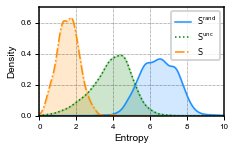

In [59]:
TITLE = 'Binned Trajectory Overall Individual Entropy Distribution by Domain'
# AX_COLORS = ['darkorange', 'green', 'dodgerblue',]
# ARGS = dict(xlim=(0, 10), ylim=(0, 0.9), grid=True, color=AX_COLORS)

# ax = STAT_RES[['domain_entropy_lz', 'domain_entropy_shannon', 'domain_entropy_random',]] \
#        .plot.kde(**ARGS)

AX_COLORS = ['dodgerblue', 'green', 'darkorange', ]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 0.7), color=AX_COLORS)

ax = STAT_RES[['domain_entropy_random', 'domain_entropy_shannon', 'domain_entropy_lz', ]] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
    
# ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
# ax.set_xlabel('Entropy by Domain')
ax.legend(['$S^{rand}$', '$S^{unc}$',  '$S$'])
ax.set_xlabel('Entropy')

# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['1.2989', '3.2849', '4.8821']

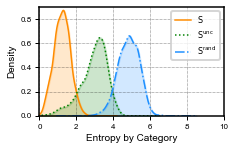

In [60]:
TITLE = 'Binned Trajectory Overall Individual Entropy Distribution by Category'
AX_COLORS = ['darkorange', 'green', 'dodgerblue',]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 0.9), color=AX_COLORS)

ax = STAT_RES[['category_entropy_lz', 'category_entropy_shannon', 'category_entropy_random',]] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
ax.set_xlabel('Entropy by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.0073', '0.5083', '0.8308']

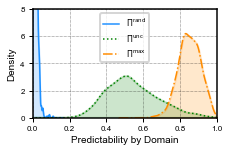

In [61]:
TITLE = 'Binned Trajectory Overall Individual Predictability Distribution by Domain'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = STAT_RES[['domain_pi_rand', 'domain_pi_unc', 'domain_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'])
ax.set_xlabel('Predictability by Domain')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.0276', '0.5443', '0.8577']

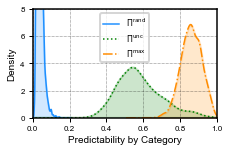

In [62]:
TITLE = 'Binned Trajectory Overall Individual Predictability Distribution by Category'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = STAT_RES[['category_pi_rand', 'category_pi_unc', 'category_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'])
ax.set_xlabel('Predictability by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

### Gender

- Section 6.1 in the article.
- Figure 8a in the article.

In [64]:
TEMP = STAT_RES.merge(USERS[['user', 'gender', 'age_recode']], on='user')

['1.6878', '1.6998']

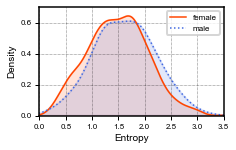

In [67]:
ARGS = dict(grid=True, xlim=(0, 3.5), ylim=(0, 0.7))

VALS = ['female', 'male']

TYPE = 'Entropy'
ATTRIBUTE = 'gender'
# COLORS = plt.cm.get_cmap('plasma', len(VALS))
AX_COLORS = ['orangered', 'royalblue']
fig, ax = plt.subplots(1, 1)

for val, color in zip(VALS, AX_COLORS):
    TEMP.query(f"{ATTRIBUTE} == '{val}'")[['domain_entropy_lz']] \
        .plot.kde(ax=ax, color=color, **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Entropy')
# ax.get_figure().savefig(f"./figures/results/entropy-dist-per-gender.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.8373', '0.8301']

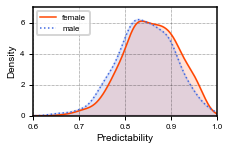

In [69]:
ARGS = dict( grid=True, xlim=(0.6, 1), ylim=(0, 7),)

VALS = ['female', 'male']

TYPE = 'Predictability'
ATTRIBUTE = 'gender'
AX_COLORS = ['orangered', 'royalblue']
fig, ax = plt.subplots(1, 1)

for val, color in zip(VALS, AX_COLORS):
    TEMP.query(f"{ATTRIBUTE} == '{val}'")[['domain_pi_max']] \
        .plot.kde(ax=ax, color=color, **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Predictability')
# ax.get_figure().savefig(f"./figures/results/predictability-dist-per-gender-v2.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

### Age

- Section 6.1 in the article.
- Figure 8b in the article.

['1.1101', '1.6000', '1.8106', '1.6803', '1.4621']

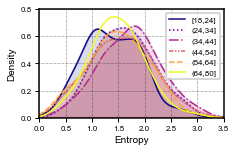

In [75]:
ARGS = dict(grid=True, xlim=(0, 3.5), ylim=(0, 0.8), )

VALS = ['[18,24]', '(24,34]', '(34,44]', '(44,54]', '(54,64]', '(64,80]'] # list(filter(lambda x: not pd.isnull(x), users.age_recode.unique().tolist()))

TYPE = 'Entropy'
ATTRIBUTE = 'age_recode'
AX_COLORS = plt.cm.get_cmap('plasma', len(VALS))
fig, ax = plt.subplots(1, 1)

for i, val in zip(count(), VALS):
    TEMP.query(f"{ATTRIBUTE} == '{val}'")[['domain_entropy_lz']] \
        .plot.kde(ax=ax, color=AX_COLORS(i), **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for i, line, style in zip(count(), ax.get_lines(), styles):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=AX_COLORS(i), alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Entropy')
# ax.get_figure().savefig(f"./figures/results/entropy-dist-per-age.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.8867', '0.8319', '0.8218', '0.8664', '0.8587']

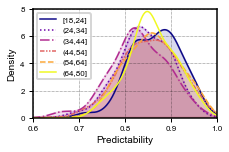

In [77]:
ARGS = dict(grid=True, xlim=(0.6, 1), ylim=(0, 8), )

VALS = ['[18,24]', '(24,34]', '(34,44]', '(44,54]', '(54,64]', '(64,80]'] # list(filter(lambda x: not pd.isnull(x), users.age_recode.unique().tolist()))

TYPE = 'Predictability'
ATTRIBUTE = 'age_recode'
AX_COLORS = plt.cm.get_cmap('plasma', len(VALS))
fig, ax = plt.subplots(1, 1)

for i, val in zip(count(), VALS):
    TEMP.query(f"{ATTRIBUTE} == '{val}'")[['domain_pi_max']] \
        .plot.kde(ax=ax, color=AX_COLORS(i), **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for i, line, style in zip(count(), ax.get_lines(), styles):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=AX_COLORS(i), alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Predictability')
# ax.get_figure().savefig(f"./figures/results/predictability-dist-per-age-v2.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.8867', '0.8218', '0.8587']

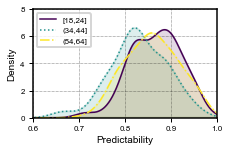

In [80]:
ARGS = dict(grid=True, xlim=(0.6, 1), ylim=(0, 8), )

VALS = ['[18,24]', '(34,44]', '(54,64]',] # list(filter(lambda x: not pd.isnull(x), users.age_recode.unique().tolist()))

TYPE = 'Predictability'
ATTRIBUTE = 'age_recode'
AX_COLORS = plt.cm.get_cmap('viridis', len(VALS))
fig, ax = plt.subplots(1, 1)

for i, val in zip(count(), VALS):
    TEMP.query(f"{ATTRIBUTE} == '{val}'")[['domain_pi_max']] \
        .plot.kde(ax=ax, color=AX_COLORS(i), **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for i, line, style in zip(count(), ax.get_lines(), styles):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=AX_COLORS(i), alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Predictability')
# ax.get_figure().savefig(f"./figures/results/predictability-dist-per-age-v3.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

## Non-Stationary Trajectory $T^{binNonStat}$

- Section 6 in the article.
- Figure 6b in the article.

['6.5443', '5.0565', '3.8209']

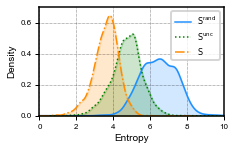

In [85]:
TITLE = 'Non-stationary Trajectory Overall Individual Entropy Distribution by Domain'
# AX_COLORS = ['darkorange', 'green', 'dodgerblue',]
# ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 0.9), color=AX_COLORS)
# ax = BIN_NON_STAT_RES[['domain_entropy_lz', 'domain_entropy_shannon', 'domain_entropy_random',]] \
#        .plot.kde(**ARGS,)

AX_COLORS = ['dodgerblue', 'green', 'darkorange', ]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 0.7), color=AX_COLORS)

ax = BIN_NON_STAT_RES[['domain_entropy_random', 'domain_entropy_shannon',  'domain_entropy_lz', ]] \
        .plot.kde(**ARGS,)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
# ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
# ax.set_xlabel('Entropy by Domain')
ax.legend(['$S^{rand}$', '$S^{unc}$', '$S$'])
ax.set_xlabel('Entropy')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['2.8676', '3.5757', '4.8821']

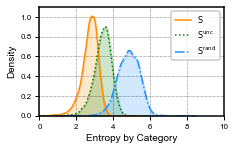

In [86]:
TITLE = 'Non-stationary Trajectory Overall Individual Entropy Distribution by Category'
AX_COLORS = ['darkorange', 'green', 'dodgerblue',]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 1.1), color=AX_COLORS)

ax = BIN_NON_STAT_RES[['category_entropy_lz', 'category_entropy_shannon', 'category_entropy_random']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
ax.set_xlabel('Entropy by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

[0.007305104761358018, 0.38620216548731884, 0.5810804511249597]


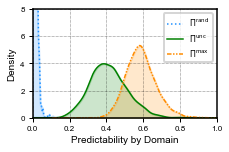

In [75]:
TITLE = 'Non-stationary Trajectory Overall Individual Predictability Distribution by Domain'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = BIN_NON_STAT_RES[['domain_pi_rand', 'domain_pi_unc', 'domain_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'])
ax.set_xlabel('Predictability by Domain')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.0276', '0.4893', '0.6124']

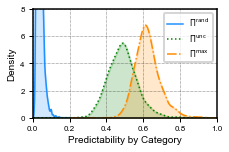

In [87]:
TITLE = 'Non-stationary Trajectory Overall Individual Predictability Distribution by Category'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = BIN_NON_STAT_RES[['category_pi_rand', 'category_pi_unc', 'category_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'])
ax.set_xlabel('Predictability by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

## Sequential Non-Stationary Trajectory $T^{seqNonStat}$

- Section 6 in the article.
- Figure 6c in the article.

['3.1462', '4.8154', '6.9222']

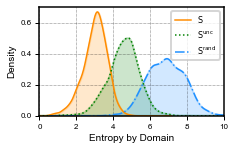

In [90]:
TITLE = 'Sequential Non-stationary Trajectory Overall Individual Entropy Distribution by Domain'
AX_COLORS = ['darkorange', 'green', 'dodgerblue', ]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 0.7), color=AX_COLORS)

ax = SEQ_NON_STAT_RES[['domain_entropy_lz', 'domain_entropy_shannon', 'domain_entropy_random', ]] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
ax.set_xlabel('Entropy by Domain')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['2.4137', '3.4423', '5.0734']

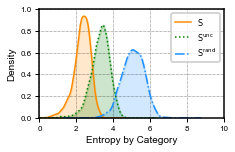

In [92]:
TITLE = 'Sequential Non-stationary Trajectory Overall Individual Entropy Distribution by Category'
AX_COLORS = ['darkorange', 'green', 'dodgerblue', ]
ARGS = dict(grid=True, xlim=(0, 10), ylim=(0, 1), color=AX_COLORS)

ax = SEQ_NON_STAT_RES[['category_entropy_lz', 'category_entropy_shannon', 'category_entropy_random']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$S$', '$S^{unc}$', '$S^{rand}$'])
ax.set_xlabel('Entropy by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.0056', '0.4598', '0.6767']

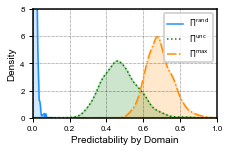

In [93]:
TITLE = 'Sequential Non-stationary Trajectory Overall Individual Predictability Distribution by Domain'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = SEQ_NON_STAT_RES[['domain_pi_rand', 'domain_pi_unc', 'domain_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'])
ax.set_xlabel('Predictability by Domain')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

['0.0233', '0.5423', '0.6964']

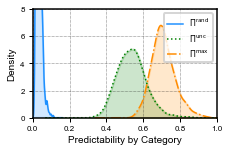

In [94]:
TITLE = 'Sequential Non-stationary Trajectory Overall Individual Predictability Distribution by Category'
AX_COLORS = ['dodgerblue', 'green', 'darkorange']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8), color=AX_COLORS)

ax = SEQ_NON_STAT_RES[['category_pi_rand', 'category_pi_unc', 'category_pi_max']] \
        .plot.kde(**ARGS)

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.2)
    maxes.append(x[np.where(y == max(y))][0])
    
ax.legend(['$\Pi^{rand}$', '$\Pi^{unc}$', '$\Pi^{max}$'], loc=1)
ax.set_xlabel('Predictability by Category')
# ax.get_figure().savefig(f"./figures/results/{TITLE.replace(' ', '-')}.pdf", bbox_inches='tight')
[ f'{m:.4f}' for m in maxes ]

# KS Tests

- Section 6.1 in the article.

In [80]:
def get_trajectory(var):
    if isinstance(var, str):
        if   var == 'non-stationary'           : return BIN_NON_STAT_RES.merge(USERS, on='user')
        elif var == 'sequential-non-stationary': return SEQ_NON_STAT_RES.merge(USERS, on='user')
        elif var == 'stationary'               : return STAT_RES.merge(USERS, on='user')
        else                                   : return None
    else:
        return var

    
def highlight_cols(row, rate, pairs):
    """Higlights statistically significant cells with applying Bonferroni Correction."""
    return ['background-color: crimson; color: white'] if row.p_value < (rate / pairs) else ['']


def apply_ks_test(traj, attribute, feature, metric, exclude_attr_vars=[]):
    
    ATTR    = attribute
    FEATURE = feature
    METRIC  = metric
    DF      = get_trajectory(traj)

    ATTR_VALS = set(DF[ATTR].dropna().unique().tolist()).difference(set(exclude_attr_vars))
    results = []

    for VAR_1, VAR_2 in combinations(ATTR_VALS, 2):
        temp = ks_2samp(
            DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_1)][f'{FEATURE}_{METRIC}'],
            DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_2)][f'{FEATURE}_{METRIC}']
        )
        results.append(
            (traj, ATTR, FEATURE, METRIC, VAR_1, VAR_2, temp.statistic, temp.pvalue)
        )

    return pd.DataFrame(results, columns=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2', 'ks_statistic', 'p_value'])
    
    
def apply_cliffs_d(traj, attribute, feature, metric, exclude_attr_vars=[]):
    
    ATTR = attribute
    FEATURE = feature
    METRIC = metric
    DF = get_trajectory(traj)

    ATTR_VALS = set(DF[ATTR].dropna().unique().tolist()).difference(set(exclude_attr_vars))
    results = []

    for VAR_1, VAR_2 in combinations(ATTR_VALS, 2):
        arr_1 = DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_1)][f'{FEATURE}_{METRIC}'].tolist()
        arr_2 = DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_2)][f'{FEATURE}_{METRIC}'].tolist()
        gt, lt = 0, 0
        for a1 in arr_1:
            for a2 in arr_2:
                if a1 > a2: gt += 1
                if a1 < a2: lt += 1
        results.append(
            (traj, ATTR, FEATURE, METRIC, VAR_1, VAR_2, (lt-gt)/(len(arr_1) * len(arr_2)))
        )
    
    return pd.DataFrame(results, columns=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2', 'cliffs_d'])


## Gender

- Section 6.1 Gender


In [92]:
apply_ks_test('stationary', 'gender', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'gender', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=1), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,gender,domain,pi_max,female,male,0.0866,8.01e-03,-0.1145


## Age

- Section 6.1 Age in the article
- Table 2 in the article.

In [82]:
apply_ks_test('stationary', 'age_recode', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'age_recode', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=15), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,age_recode,domain,pi_max,"(54,64]","[18,24]",0.0986,2.24e-01,0.0833
1,stationary,age_recode,domain,pi_max,"(54,64]","(34,44]",0.2170,3.19e-06,-0.2535
2,stationary,age_recode,domain,pi_max,"(54,64]","(64,80]",0.1084,4.78e-01,-0.0012
3,stationary,age_recode,domain,pi_max,"(54,64]","(24,34]",0.1298,1.11e-02,-0.1500
4,stationary,age_recode,domain,pi_max,"(54,64]","(44,54]",0.0567,6.12e-01,-0.0485
5,stationary,age_recode,domain,pi_max,"[18,24]","(34,44]",0.2671,1.83e-06,-0.3417
6,stationary,age_recode,domain,pi_max,"[18,24]","(64,80]",0.1429,2.52e-01,-0.0838
7,stationary,age_recode,domain,pi_max,"[18,24]","(24,34]",0.1943,8.31e-04,-0.2406
8,stationary,age_recode,domain,pi_max,"[18,24]","(44,54]",0.1338,3.40e-02,-0.1321
9,stationary,age_recode,domain,pi_max,"(34,44]","(64,80]",0.2861,2.18e-04,0.2750


## Children

In [83]:
apply_ks_test('stationary', 'children', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'children', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=6), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,children,domain,pi_max,0 children,2 children,0.0864,3.14e-01,-0.0506
1,stationary,children,domain,pi_max,0 children,3 children or +,0.1168,4.97e-01,0.0806
2,stationary,children,domain,pi_max,0 children,1 child,0.0769,2.07e-01,-0.0462
3,stationary,children,domain,pi_max,2 children,3 children or +,0.1597,2.75e-01,0.1258
4,stationary,children,domain,pi_max,2 children,1 child,0.0804,6.16e-01,0.0034
5,stationary,children,domain,pi_max,3 children or +,1 child,0.1370,3.87e-01,-0.1238


## Income

In [84]:
apply_ks_test('stationary', 'hh_income', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'hh_income', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=10), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,hh_income,domain,pi_max,_under 1000,1000 to 2000,0.1580,3.19e-02,-0.1269
1,stationary,hh_income,domain,pi_max,_under 1000,3000 to 4000,0.2702,2.98e-05,-0.2895
2,stationary,hh_income,domain,pi_max,_under 1000,2000 to 3000,0.2037,1.45e-03,-0.1957
3,stationary,hh_income,domain,pi_max,_under 1000,over 4000,0.2937,9.52e-06,-0.3479
4,stationary,hh_income,domain,pi_max,1000 to 2000,3000 to 4000,0.1299,4.07e-02,-0.1488
5,stationary,hh_income,domain,pi_max,1000 to 2000,2000 to 3000,0.0796,3.25e-01,-0.0629
6,stationary,hh_income,domain,pi_max,1000 to 2000,over 4000,0.1658,6.58e-03,-0.2078
7,stationary,hh_income,domain,pi_max,3000 to 4000,2000 to 3000,0.0965,1.99e-01,0.0875
8,stationary,hh_income,domain,pi_max,3000 to 4000,over 4000,0.0750,6.68e-01,-0.0634
9,stationary,hh_income,domain,pi_max,2000 to 3000,over 4000,0.1185,8.88e-02,-0.1481


## Residence

In [85]:
apply_ks_test('stationary', 'place_of_residence', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'place_of_residence', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=21), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","5: 100,000 - 499,999 inhabitants",0.0732,6.94e-01,0.0157
1,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","6: 500,000 inhabitants and more",0.0792,5.42e-01,0.0114
2,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","1: 2,000 - 4,999 inhabitants",0.1543,6.70e-02,0.1289
3,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","2: 5,000 - 19,999 inhabitants",0.1153,1.63e-01,-0.0858
4,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","0: Less than 2,000 inhabitants",0.0801,7.50e-01,0.0131
5,stationary,place_of_residence,domain,pi_max,"4: 50,000 - 99,999 inhabitants","3: 20,000 - 49,999 inhabitants",0.0773,6.79e-01,-0.0175
6,stationary,place_of_residence,domain,pi_max,"5: 100,000 - 499,999 inhabitants","6: 500,000 inhabitants and more",0.0339,9.97e-01,-0.0052
7,stationary,place_of_residence,domain,pi_max,"5: 100,000 - 499,999 inhabitants","1: 2,000 - 4,999 inhabitants",0.1236,1.37e-01,0.0954
8,stationary,place_of_residence,domain,pi_max,"5: 100,000 - 499,999 inhabitants","2: 5,000 - 19,999 inhabitants",0.0976,1.82e-01,-0.1004
9,stationary,place_of_residence,domain,pi_max,"5: 100,000 - 499,999 inhabitants","0: Less than 2,000 inhabitants",0.0514,9.74e-01,-0.0023


## Education

In [86]:
apply_ks_test('stationary', 'education', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'education', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=6), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,education,domain,pi_max,1: Volks/hauptschule,"3: Abitur, (Fach-)Hochschulreife",0.1207,9.45e-03,-0.1383
1,stationary,education,domain,pi_max,1: Volks/hauptschule,4: No qualification (yet),0.1418,6.58e-01,0.0917
2,stationary,education,domain,pi_max,1: Volks/hauptschule,2: Weiterfuerhende Schule,0.0496,7.99e-01,0.0183
3,stationary,education,domain,pi_max,"3: Abitur, (Fach-)Hochschulreife",4: No qualification (yet),0.2143,1.48e-01,0.2333
4,stationary,education,domain,pi_max,"3: Abitur, (Fach-)Hochschulreife",2: Weiterfuerhende Schule,0.1243,2.32e-04,0.1596
5,stationary,education,domain,pi_max,4: No qualification (yet),2: Weiterfuerhende Schule,0.1172,8.36e-01,-0.0720


## Family

In [87]:
apply_ks_test('stationary', 'family', 'domain', 'pi_max') \
    .merge(apply_cliffs_d('stationary', 'family', 'domain', 'pi_max'), on=['trajectory', 'attribute', 'feature', 'metric', 'var_1', 'var_2']) \
    .style \
        .background_gradient('Blues', subset='ks_statistic') \
        .background_gradient('Greens', subset='p_value') \
        .background_gradient('Oranges', subset='cliffs_d') \
        .apply(partial(highlight_cols, rate=0.05, pairs=15), subset=['p_value'], axis=1) \
        .format({'ks_statistic': '{0:.4f}', 'cliffs_d': '{0:.4f}', 'p_value': '{0:.2e}'})

,trajectory,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,stationary,family,domain,pi_max,1: Married,2: Civil Partnership,0.1673,5.84e-01,-0.0883
1,stationary,family,domain,pi_max,1: Married,"3: Single, living with partner",0.0699,4.82e-01,-0.0250
2,stationary,family,domain,pi_max,1: Married,"5: Divorced/widowed, living with partner",0.2023,2.38e-02,0.1668
3,stationary,family,domain,pi_max,1: Married,"4: Single, not living with partner",0.1031,8.89e-03,0.1267
4,stationary,family,domain,pi_max,1: Married,"6: Divorced/widowed, not living with partner",0.1830,2.48e-04,0.2322
5,stationary,family,domain,pi_max,2: Civil Partnership,"3: Single, living with partner",0.1630,6.56e-01,0.0722
6,stationary,family,domain,pi_max,2: Civil Partnership,"5: Divorced/widowed, living with partner",0.3309,5.28e-02,0.2479
7,stationary,family,domain,pi_max,2: Civil Partnership,"4: Single, not living with partner",0.2640,1.01e-01,0.2389
8,stationary,family,domain,pi_max,2: Civil Partnership,"6: Divorced/widowed, not living with partner",0.3271,2.74e-02,0.3393
9,stationary,family,domain,pi_max,"3: Single, living with partner","5: Divorced/widowed, living with partner",0.2442,7.80e-03,0.1914
